In [483]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from matplotlib.ticker import FuncFormatter
import glob
import os
import datetime as datetime 
import seaborn as sns
import re

In [530]:
def data_load(path):
    """
    Load data file.
    """
    df = pd.read_excel(path)
    # remove the last column
    # df = df.iloc[:, :-1]
    # Calculate the 'Age' of the vehicle
    return df


def service_year_calculate(df):
    """
    Calculate the service year of the vehicle.
    """
    df['Retire date filled'] = df['Date Actual Retire'].fillna(df['Actual Replacement date'])
    df['Retire date filled'] = df['Retire date filled'].fillna(df['Today'])
    df['service year'] =  (df['Retire date filled'] - df['Date Accepted']).dt.days/365
    df['service year'] = df['service year'].round(1)
    return  df['service year']


def get_retired_vehicle(df):
    """
    Get the retired data.
    """
    df['Date Actual Retire'] = pd.to_datetime(df['Date Actual Retire'], errors='coerce')
    df['Actual Replacement date'] = pd.to_datetime(df['Actual Replacement date'], errors='coerce')
    # filter out the vehicles that have no 'Retirement Date' and 'replacement date' at the same time
    results = df[df[['Date Actual Retire', 'Actual Replacement date']].notna().any(axis=1)]
    results['service year'] = service_year_calculate(results)
    return results


def total_vkt(df):
    """
    Calculate the total VKT of the vehicle.
    """
    df['Retire date filled'] = df['Date Actual Retire'].fillna(df['Actual Replacement date'])
    df['Retire date filled'] = df['Retire date filled'].fillna(df['Today'])
    
    df['num_days'] = (df['Retire date filled'] - df['Date Accepted']).dt.days
    df['Current Odometer Reading'] = (
                    df['Current Odometer Reading']
                    .astype(str)  # Convert everything to string first
                    .str.replace(",", "", regex=False)  # Remove commas
                )
    df['Current Odometer Reading'] = pd.to_numeric(df['Current Odometer Reading'], errors='coerce')
    df['Total VKT'] = 365 * df['Current Odometer Reading'] / df['num_days'] # annual equivalent vkt
    df['Total VKT'] = df['Total VKT'].round(0)
    return df['Total VKT']

In [531]:
data_dir_new = '../../data/Aramco Leased Vehicles - from 2012 up-to-01-30-2025 - Including VTK and Acceptance Date.xlsx'
data_dir_old = '../../data/Aramco Leased Vehicles - from 2012 up-to-date with make and model.xlsx'
fuel_type_path = '../../data/Aramco Leased Vehicles - from 2012 up-to-date - Updated IMEI.xlsx'
df_new = data_load(data_dir_new)
df_old = data_load(data_dir_old)
df_updateIMEI = data_load(fuel_type_path)
df_new['Fuel Type'] = ''
# Replace columns 'Make' and 'Model' with 'Make' and 'Model' from the old data
# Create mappings
colA_map = df_old.set_index('Vehicle Number')['Make']
colB_map = df_old.set_index('Vehicle Number')['Model']
# Replace only where match exists
df_new['Make'] = df_new['Vehicle Number'].map(colA_map).fillna(df_new['Make'])
df_new['Model'] = df_new['Vehicle Number'].map(colB_map).fillna(df_new['Model'])
df_new['Fuel Type'] = df_new['Vehicle Number'].map(df_updateIMEI.set_index('Vehicle Number')['Fuel Type'])
df_new['IMEI'] = df_new['Vehicle Number'].map(df_updateIMEI.set_index('Vehicle Number')['IMEI'])
df_new.loc[df_new['Fuel Type'].isna() | (df_new['Fuel Type'].str.strip() == ''), 'Fuel Type'] = 'Gasoline'
df_new['IMEI'] = df_new['IMEI'].astype(str)

# Filter out the data before model year 2008
print(df_new[df_new['Model Year'] >= 2008].shape, df_new[df_new['Primary Status'] == 'Total Loss'].shape,\
      df_new[df_new['Fuel Type']=='Diesel'].shape, df_new[~df_new['IMEI'].str.isnumeric()].shape)
df_new = df_new[df_new['Model Year'] >= 2008]
df_new['Today'] = pd.to_datetime(datetime.date(2025, 5, 1))
# Remove rows with the primary status of 'Total Loss'
df_new = df_new[df_new['Primary Status'] != 'Total Loss']
df_new.head()

(25228, 14) (53, 14) (372, 14) (3324, 14)


,Primary Status,IMEI,Vehicle Number,Make,Model,Model Year,Activity Type,Activity Type Description,Date Actual Retire,Actual Replacement date,Date Accepted,Current Odometer Reading,Vehicle Type,Fuel Type,Today
0,Retired,No Data Available (No Records),RT9971,Chevy,Tahoe,2008,TLPB2,Carryall 4x4,2013-03-31,NaT,2012-07-08,"160,282",SUV,Gasoline,2025-05-01
1,Retired,No Data Available (No Records),RT9972,Chevy,Tahoe,2008,TLPB2,Carryall 4x4,2013-03-31,NaT,2012-07-08,"86,302",SUV,Gasoline,2025-05-01
2,Retired,No Data Available (No Records),RT9973,Chevy,Tahoe,2008,TLPB2,Carryall 4x4,2013-03-31,NaT,2012-07-08,"166,570",SUV,Gasoline,2025-05-01
3,Retired,No Data Available (No Records),RT9974,Chevy,Tahoe,2008,TLPB2,Carryall 4x4,2013-03-31,NaT,2012-07-08,"11,023",SUV,Gasoline,2025-05-01
4,Retired,No Data Available (No Records),RT9975,Chevy,Tahoe,2008,TLPB2,Carryall 4x4,2013-03-31,NaT,2012-07-08,"135,688",SUV,Gasoline,2025-05-01


In [532]:
print(df_new.shape, df_new['Activity Type Description'].nunique(), df_new.dtypes, df_new.shape)
df_new.to_excel('../../results/new_results/fleet_data_merged_results.xlsx', index=False)

(25176, 15) 93 Primary Status                       object
IMEI                                 object
Vehicle Number                       object
Make                                 object
Model                                object
Model Year                            int64
Activity Type                        object
Activity Type Description            object
Date Actual Retire           datetime64[ns]
Actual Replacement date      datetime64[ns]
Date Accepted                datetime64[ns]
Current Odometer Reading             object
Vehicle Type                         object
Fuel Type                            object
Today                        datetime64[ns]
dtype: object (25176, 15)


In [537]:
mdt_g = df_new[(df_new['Vehicle Type']=='Medium-duty truck') & (df_new['Fuel Type']=='Gasoline')].shape[0]
mdt_d = df_new[(df_new['Vehicle Type']=='Medium-duty truck') & (df_new['Fuel Type']=='Diesel')].shape[0]
ldt_g = df_new[(df_new['Vehicle Type']=='Light-duty truck') & (df_new['Fuel Type']=='Gasoline')].shape[0]
ldt_d = df_new[(df_new['Vehicle Type']=='Light-duty truck') & (df_new['Fuel Type']=='Diesel')].shape[0]
# bus_g = df_new[(df_new['Vehicle Type']=='Bus') & (df_new['Fuel Type']=='Gasoline')].shape[0]
# bus_d = df_new[(df_new['Vehicle Type']=='Bus') & (df_new['Fuel Type']=='Diesel')].shape[0]
sedan_g = df_new[(df_new['Vehicle Type']=='Sedan') & (df_new['Fuel Type']=='Gasoline')].shape[0]
sedan_d = df_new[(df_new['Vehicle Type']=='Sedan') & (df_new['Fuel Type']=='Diesel')].shape[0]
suv_g = df_new[(df_new['Vehicle Type']=='SUV') & (df_new['Fuel Type']=='Gasoline')].shape[0]
suv_d = df_new[(df_new['Vehicle Type']=='SUV') & (df_new['Fuel Type']=='Diesel')].shape[0]
sec_g = df_new[(df_new['Vehicle Type']=='Security Patrol') & (df_new['Fuel Type']=='Gasoline')].shape[0]
sec_d = df_new[(df_new['Vehicle Type']=='Security Patrol') & (df_new['Fuel Type']=='Diesel')].shape[0]
# van = df_new[df_new['Suggested_Classification']=='van'].shape[0]
total = mdt_g + mdt_d + ldt_g + ldt_d  + sedan_g + sedan_d + suv_g + suv_d + sec_g + sec_d
print(sedan_g, sedan_d, suv_g, suv_d, sec_g, sec_d, ldt_g, ldt_d, mdt_g, mdt_d, total, df_new.shape[0])

7841 0 6824 0 646 1 7536 92 1973 263 25176 25176


In [545]:
retired_vehicle_df = get_retired_vehicle(df_new)
print(retired_vehicle_df.shape)
retired_vehicle_df.head()
retired_vehicle_df.to_excel('../../results/new_results/retired_vehicle_data.xlsx', index=False)
# num_total_vehicle_type = fleet_df['Activity Type Description'].nunique()
# num_retired_vehicle_type = retired_vehicle_df['Activity Type Description'].nunique()
# print(num_retired_vehicle_type, num_total_vehicle_type)
# # Get the vehicle types not in retired vehicles
# types_not_in_retired = fleet_df[~fleet_df['Activity Type Description'].isin(retired_vehicle_df['Activity Type Description'])]['Activity Type Description'].unique()
# print(types_not_in_retired) # ["D Van 12' Hyd. Tailg", 'Re-lamper Truck, 4x', 'Crane Truck 4X2, Die','Comm Emerg. Equip V']

/var/folders/rh/5tkty3715h119sm4y35zw4dr0000gn/T/ipykernel_3810/892412345.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Retire date filled'] = df['Date Actual Retire'].fillna(df['Actual Replacement date'])
/var/folders/rh/5tkty3715h119sm4y35zw4dr0000gn/T/ipykernel_3810/892412345.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Retire date filled'] = df['Retire date filled'].fillna(df['Today'])
/var/folders/rh/5tkty3715h119sm4y35zw4dr0000gn/T/ipykernel_3810/892412345.py:18: SettingWithCopy

(14048, 17)


In [ ]:
retired_vehicle_df[retired_vehicle_df['Model Year']>=2024].shape[0]

50

In [627]:
# Calculate survival rate by vehicle type
def calculate_survival_pattern(df):
    vehicle_types = df['Vehicle Type'].unique()
    survival_rate = {}

    for veh_type in vehicle_types:
        num_vehicles = len(df[df['Vehicle Type'] == veh_type])
        survival_rate[veh_type] = []
        df['service year rounded'] = df['service year'].round()
        num_retired = 0
        max_age = df.loc[df['Vehicle Type'] == veh_type, 'service year rounded'].max()
        vehicle_age = range(int(df.loc[df['Vehicle Type'] == veh_type, 'service year rounded'].max()) + 1)
        for age in vehicle_age:
            num_retired += len(df[(df['Vehicle Type'] == veh_type) & (df['service year rounded'] == age)])
            try:
                survival_rate[veh_type].append((num_vehicles - num_retired)/num_vehicles)
            except ZeroDivisionError:
                survival_rate[veh_type].append(0) 
                print(f"❌ Failed to fetch website: {veh_type} at age {age}")

    survival_rate_df = pd.DataFrame.from_dict(survival_rate, orient='index').fillna(0)
    survival_rate_df.head()

    return survival_rate_df

# Calculate survival rate by vehicle type and service year
def calculate_survival_pattern_by_service_year(df):
    df = df.copy()
    df['service year rounded'] = df['service year'].round().astype(int)
    df['start service year'] = df['Date Accepted'].dt.year
    survival_data = {}

    for veh_type in df['Vehicle Type'].unique():
        sub_df = df[df['Vehicle Type'] == veh_type]
        for model_year in sub_df['start service year'].unique():
            model_df = sub_df[sub_df['start service year'] == model_year]
            num_vehicles = len(model_df)
            if num_vehicles == 0:
                continue

            # Calculate survival rate at each age
            age_counts = model_df['service year rounded'].value_counts().sort_index()
            max_age = int(model_df['service year rounded'].max())
            num_retired = 0
            survival_curve = []

            for age in range(max_age + 1):
                retired_this_age = age_counts.get(age, 0)
                num_retired += retired_this_age
                survival = (num_vehicles - num_retired) / num_vehicles if num_vehicles else 0
                survival_curve.append(survival)

            survival_data[(veh_type, model_year)] = survival_curve
            
    # Find max length to align DataFrame columns (ages)
    max_len = max(len(surv) for surv in survival_data.values())
    for key in survival_data:
        survival_data[key] += [0] * (max_len - len(survival_data[key]))

    survival_rate_df = pd.DataFrame.from_dict(
    survival_data, orient='index', columns=list(range(max_len))
)
    survival_rate_df.index = pd.MultiIndex.from_tuples(survival_rate_df.index, names=['Vehicle Type', 'Model Year'])
    survival_rate_df = survival_rate_df.sort_index(level=['Vehicle Type', 'Model Year'])

    return survival_rate_df

survival_df = calculate_survival_pattern(retired_vehicle_df)
survival_df_by_model_year = calculate_survival_pattern_by_service_year(retired_vehicle_df)
survival_df_by_model_year.head()

/var/folders/rh/5tkty3715h119sm4y35zw4dr0000gn/T/ipykernel_3810/2141911711.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['service year rounded'] = df['service year'].round()


0         1         2         3         4   \
Vehicle Type     Model Year                                                
Light-duty truck 2008        1.0  1.000000  1.000000  0.996296  0.974074   
                 2009        1.0  1.000000  1.000000  1.000000  0.625000   
                 2010        1.0  1.000000  0.992366  0.988550  0.919847   
                 2011        1.0  0.994065  0.988131  0.988131  0.854599   
                 2012        1.0  1.000000  0.800000  0.400000  0.200000   

                                   5         6         7         8         9   \
Vehicle Type     Model Year                                                     
Light-duty truck 2008        0.014815  0.000000  0.000000  0.000000  0.000000   
                 2009        0.000000  0.000000  0.000000  0.000000  0.000000   
                 2010        0.656489  0.648855  0.648855  0.064885  0.000000   
                 2011        0.584570  0.572700  0.563798  0.044510  0.005935   
                 2012        0.200000  0.200000  0.000000  0.000000  0.000000   

                              10   11   12   13   14   15   16  
Vehicle Type     Model Year                                     
Light-duty truck 2008        0.0  0.0  0.0  0.0  0.0  0.0  0.0  
                 2009        0.0  0.0  0.0  0.0  0.0  0.0  0.0  
                 2010        0.0  0.0  0.0  0.0  0.0  0.0  0.0  
                 2011        0.0  0.0  0.0  0.0  0.0  0.0  0.0  
                 2012        0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [631]:
survival_df_by_model_year.to_excel('../../results/new_results/survival_rate_by_model_year.xlsx', sheet_name='Sheet1')

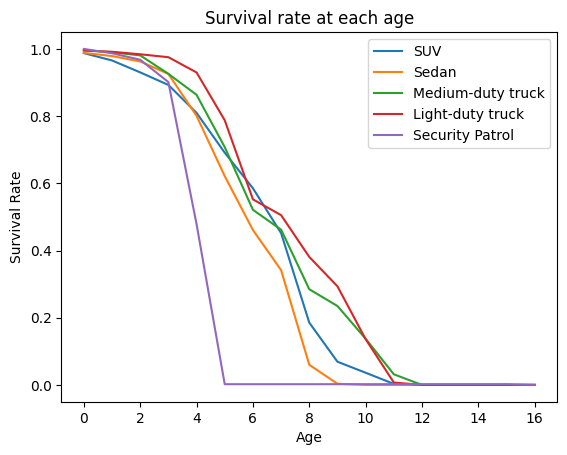

In [629]:
# Visualize the survival rate
for index, row in survival_df.iterrows():
    plt.plot(row, label=index)

plt.xlabel('Age')
plt.ylabel('Survival Rate')
plt.title('Survival rate at each age')
plt.legend()
plt.show()

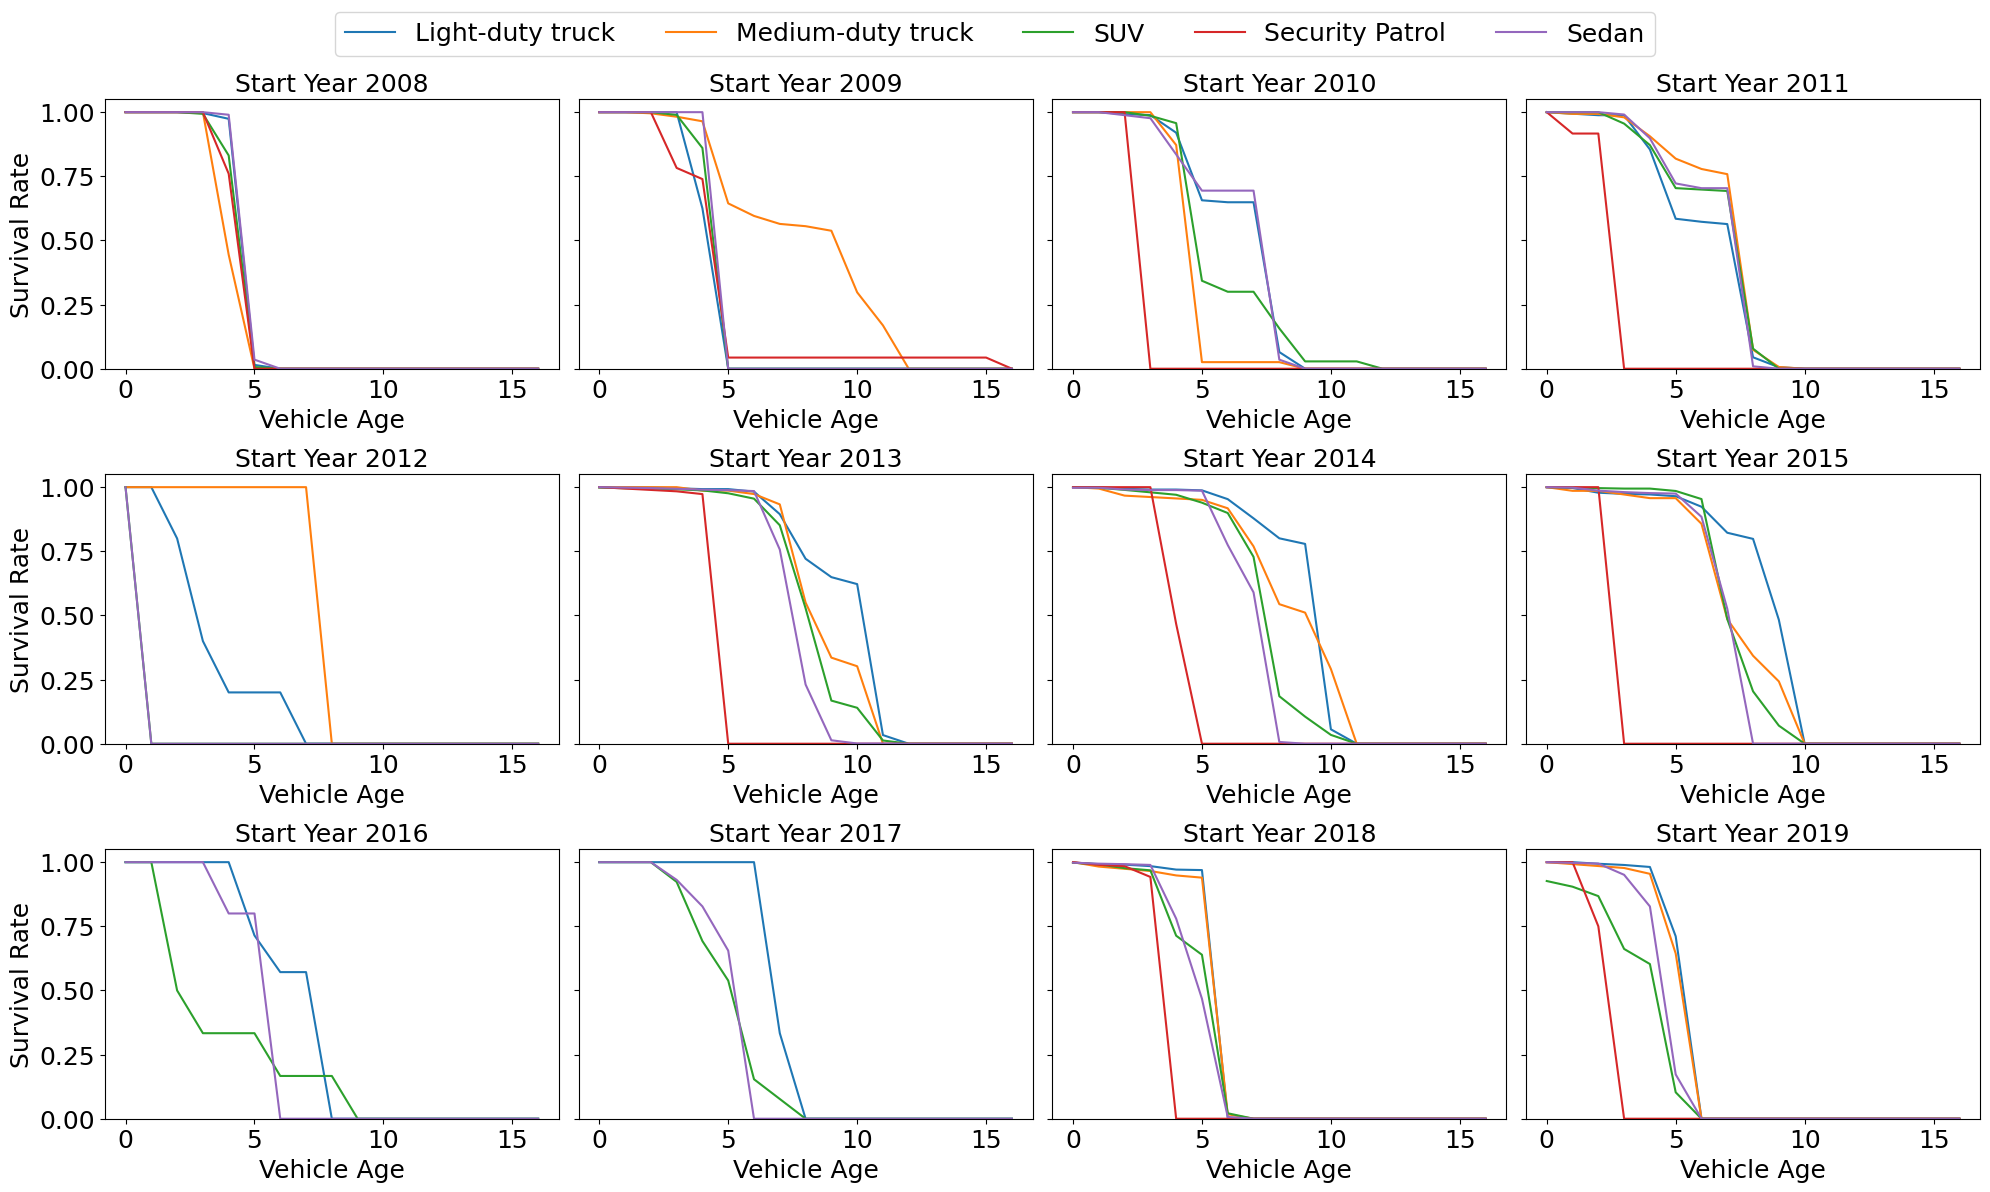

In [634]:
import math

def plot_survival_by_model_year(survival_df, start_year=2008, end_year=2019):
    model_years = [year for year in survival_df.index.get_level_values('Model Year').unique()
                   if start_year <= year <= end_year]
    vehicle_types = sorted(survival_df.index.get_level_values('Vehicle Type').unique())  # sort for consistency

    # MODIFIED: Define fixed color map for vehicle types
    default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    color_map = {veh_type: default_colors[i % len(default_colors)] for i, veh_type in enumerate(vehicle_types)}

    num_years = len(model_years)
    cols = 4
    rows = math.ceil(num_years / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows), sharey=True)
    axes = axes.flatten()

    all_handles_labels = []

    for i, model_year in enumerate(sorted(model_years)):
        ax = axes[i]
        handles = []
        labels = []

        for veh_type in vehicle_types:
            try:
                row = survival_df.loc[(veh_type, model_year)]
                # MODIFIED: Apply consistent color per vehicle type
                line, = ax.plot(row.index, row.values, label=veh_type, color=color_map[veh_type])
                handles.append(line)
                labels.append(veh_type)
            except KeyError:
                continue  # Skip missing data

        ax.set_title(f'Start Year {model_year}', fontsize=18)
        ax.set_xlabel('Vehicle Age', fontsize=18)
        if i % cols == 0:
            ax.set_ylabel('Survival Rate', fontsize=18)
        ax.tick_params(axis='both', which='major', labelsize=18)
        ax.set_ylim(0, 1.05)

        all_handles_labels.extend(zip(handles, labels))

    # Remove any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # MODIFIED: Build deduplicated legend with consistent colors
    if all_handles_labels:
        unique_labels = {}
        for handle, label in all_handles_labels:
            if label not in unique_labels:
                unique_labels[label] = handle
        fig.legend(unique_labels.values(), unique_labels.keys(),
                   loc='upper center', ncol=len(unique_labels), fontsize=18)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Call the plotting function
plot_survival_by_model_year(survival_df_by_model_year, start_year=2008, end_year=2019)

In [632]:
# Fit survival rate model
from scipy.optimize import curve_fit

# Logistic survival model
def logistic_survival(age, a, L50):
    return 1 / (1 + np.exp(a * (age / L50 - 1)))

def logistic_fixed_L50(age, a, L50_fixed):
    L50_fixed = 5.0
    return 1 / (1 + np.exp(a * (age / L50_fixed - 1)))

def model_fit_from_two_data_points(model, ages, mask, rates, veh_type, model_year, L50_fixed, results):  # only applies to the cases where there are only two valid survival rate data points (0 < rate < 1)
    try:
        model = lambda x, a: logistic_fixed_L50(x, a, L50_fixed)
        popt, _ = curve_fit(
            model,
            ages[mask],
            rates[mask],
            p0=[5],  # Initial guesses: a=5, L50=10
            bounds=([0.01], [50]) # Reasonable parameter bounds
        )
        a_est = popt[0]
        results.append({
            'Vehicle Type': veh_type,
            'Model Year': model_year,
            'a': a_est,
            'L50': L50_fixed
        })
    except RuntimeError:
        print("There is an error")  # Skip if fit fails

    return results

def model_fit_from_one_data_point(survival_df, veh_type, model_year, L50_fixed, results):
    df = survival_df.copy()
    df = df.reset_index()
    filtered_df = df[(df['Vehicle Type']==veh_type) & (df['Model Year']==model_year)]
    # Drop non-numeric columns (like 'Vehicle Type', 'Model Year') if necessary
    numeric_data = filtered_df.select_dtypes(include=[float, int])
    # Flatten the row (assuming one row) and filter values
    row = numeric_data.iloc[0]
    # Get values between 0 and 1 (exclusive)
    valid_values = row[(row > 0) & (row < 1)]

    # Separate column names (as int) and values
    columns = [int(col) for col in valid_values.index]
    values = valid_values.values.tolist()
    age = columns[0]  # Assuming only one valid age
    sur_rate = values[0]  # Assuming only one valid survival rate

    if sur_rate <= 0 or sur_rate >= 1:
        raise ValueError("Survival rate must be between 0 and 1 (exclusive)")

    denominator = (age / L50_fixed) - 1
    if denominator == 0:
        raise ValueError("Division by zero: age equals L50_fixed")

    a_est = np.log(1 / sur_rate - 1) / denominator
    results.append({
                    'Vehicle Type': veh_type,
                    'Model Year': model_year,
                    'a': a_est,
                    'L50': L50_fixed
                })
    return results

# Fit model only for model years 2008–2019
def fit_logistic_to_survival_filtered(survival_df, start_year=2008, end_year=2019):
    results = []

    for (veh_type, model_year), row in survival_df.iterrows():
        if not (start_year <= model_year <= end_year):
            continue  # Skip years outside the range

        ages = np.array(row.index).astype(float)
        rates = row.values

        # Filter valid survival values
        mask = ~np.isnan(rates) & (rates > 0) & (rates < 1)
        if mask.sum() < 1:
            continue  # Not enough points to fit
        
        if mask.sum() == 1:
            if veh_type == 'Security Patrol' and model_year == 2008:
                L50_fixed = 4.34
                results = model_fit_from_one_data_point(survival_df, veh_type, model_year, L50_fixed, results)
            elif veh_type == 'Security Patrol' and model_year == 2014:
                L50_fixed = 3.94
                results = model_fit_from_one_data_point(survival_df, veh_type, model_year, L50_fixed, results)
            elif veh_type == 'Security Patrol' and model_year == 2019:
                L50_fixed = 2.33
                results = model_fit_from_one_data_point(survival_df, veh_type, model_year, L50_fixed, results)
            elif veh_type == 'Light-duty truck' and model_year == 2009:
                L50_fixed = 4.2
                results = model_fit_from_one_data_point(survival_df, veh_type, model_year, L50_fixed, results)
            elif veh_type == 'Light-duty truck' and model_year == 2017:
                L50_fixed = 6.75
                results = model_fit_from_one_data_point(survival_df, veh_type, model_year, L50_fixed, results)
            elif veh_type == 'Medium-duty truck' and model_year == 2008:
                L50_fixed = 3.9
                results = model_fit_from_one_data_point(survival_df, veh_type, model_year, L50_fixed, results)

        if mask.sum() == 2:
            if veh_type == 'Sedan' and model_year == 2008:
                L50_fixed = 4.48
                results = model_fit_from_two_data_points(logistic_fixed_L50, ages, mask, rates, veh_type, model_year, L50_fixed, results)
            elif veh_type == 'Sedan' and model_year == 2016:
                L50_fixed = 5.375
                results = model_fit_from_two_data_points(logistic_fixed_L50, ages, mask, rates, veh_type, model_year, L50_fixed, results)
            elif veh_type == 'SUV' and model_year == 2009:
                L50_fixed = 4.42
                results = model_fit_from_two_data_points(logistic_fixed_L50, ages, mask, rates, veh_type, model_year, L50_fixed, results)
            elif veh_type == 'Security Patrol' and model_year == 2011:
                L50_fixed = 2.45
                results = model_fit_from_two_data_points(logistic_fixed_L50, ages, mask, rates, veh_type, model_year, L50_fixed, results)

        if mask.sum() > 2:
            try:
                popt, _ = curve_fit(
                    logistic_survival,
                    ages[mask],
                    rates[mask],
                    p0=[5, 10],  # Initial guesses: a=5, L50=10
                    bounds=([0.01, 1], [50, 50])  # Reasonable parameter bounds
                )
                a_est, L50_est = popt
                results.append({
                    'Vehicle Type': veh_type,
                    'Model Year': model_year,
                    'a': a_est,
                    'L50': L50_est
                })
            except RuntimeError:
                continue  # Skip if fit fails

    return pd.DataFrame(results)

logistic_params_df = fit_logistic_to_survival_filtered(survival_df_by_model_year, start_year=2008, end_year=2019)
print(logistic_params_df.head())

       Vehicle Type  Model Year          a       L50
0  Light-duty truck        2008  34.918671  4.463512
1  Light-duty truck        2009  10.727338  4.200000
2  Light-duty truck        2010   5.616113  6.684240
3  Light-duty truck        2011   5.104856  6.228868
4  Light-duty truck        2012   2.581380  2.933361


In [633]:
logistic_params_df.to_excel('../../results/new_results/logistic_params.xlsx', index=False) 

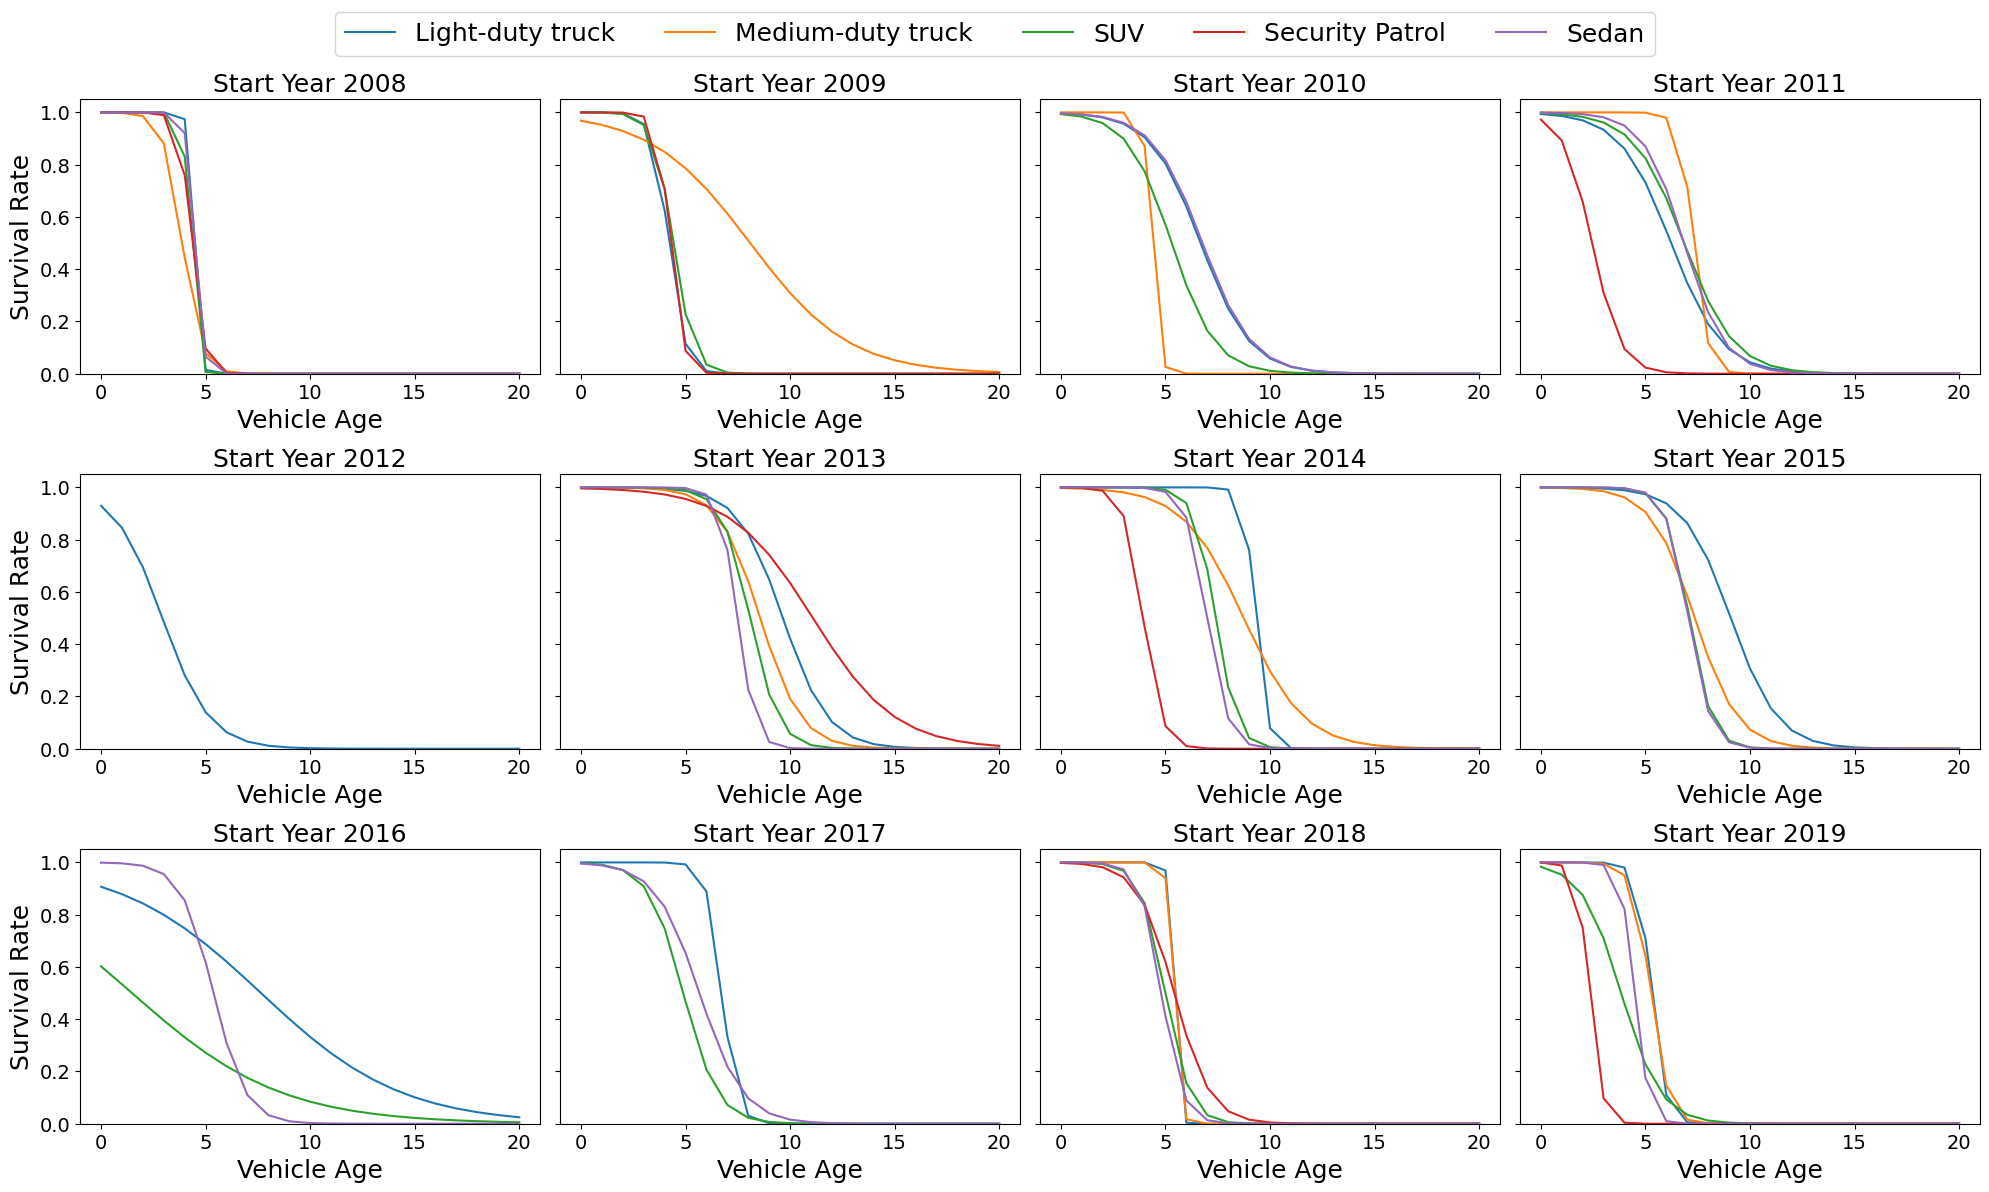

In [637]:
# Load the logistic parameters for plotting

# Get unique model years and vehicle types
model_years = sorted(logistic_params_df['Model Year'].unique())
vehicle_types = sorted(logistic_params_df['Vehicle Type'].unique())

# Define a consistent color map for vehicle types
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_map = {veh_type: default_colors[i % len(default_colors)] for i, veh_type in enumerate(vehicle_types)}

# Layout for subplots
cols = 4
rows = math.ceil(len(model_years) / cols)
fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows), sharey=True)
axes = axes.flatten()

all_handles_labels = []

# Generate plots by model year
for i, model_year in enumerate(model_years):
    ax = axes[i]
    handles = []
    labels = []

    for veh_type in vehicle_types:
        row = logistic_params_df[(logistic_params_df['Model Year'] == model_year) &
                                  (logistic_params_df['Vehicle Type'] == veh_type)]
        if not row.empty:
            a = row['a'].values[0]
            L50 = row['L50'].values[0]
            x = np.arange(0, 21)
            y = logistic_survival(x, a, L50)
            line, = ax.plot(x, y, label=veh_type, color=color_map[veh_type])
            handles.append(line)
            labels.append(veh_type)

    ax.set_title(f'Start Year {model_year}', fontsize=18)
    ax.set_xlabel('Vehicle Age', fontsize=18)
    if i % cols == 0:
        ax.set_ylabel('Survival Rate', fontsize=18)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.set_ylim(0, 1.05)

    all_handles_labels.extend(zip(handles, labels))

# Remove unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Global legend with consistent colors
if all_handles_labels:
    unique_labels = {}
    for handle, label in all_handles_labels:
        if label not in unique_labels:
            unique_labels[label] = handle
    fig.legend(unique_labels.values(), unique_labels.keys(),
               loc='upper center', ncol=len(unique_labels), fontsize=18)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

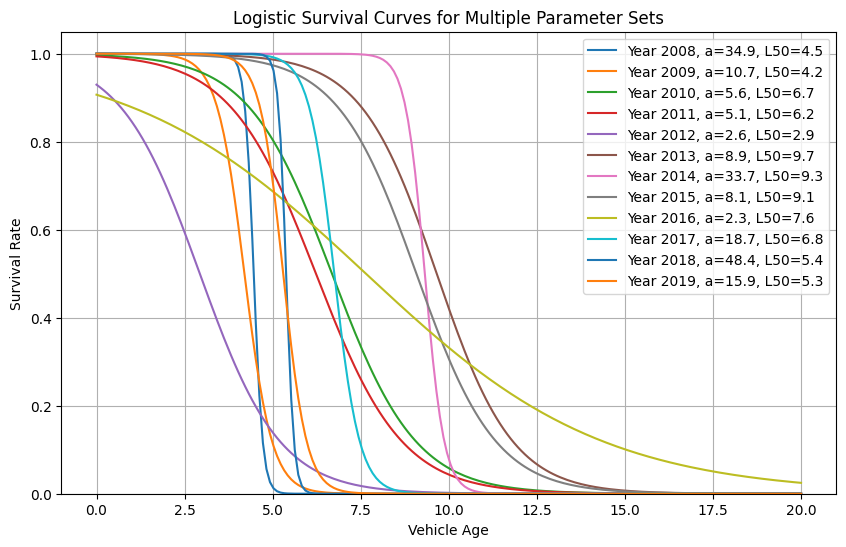

In [641]:
# Define the logistic survival function
def logistic_survival(x, a, L50):
    return 1 / (1 + np.exp(a * (x / L50 - 1)))

# Parameters
veh_type = 'Light-duty truck'
params = logistic_params_df[logistic_params_df['Vehicle Type'] == veh_type]
a_list = params['a'].tolist() # Example: 5.0
L50_list = params['L50'].tolist() # Example: 10.0
year_list = params['Model Year'].tolist() # Example: 2008, 2010, etc.

# Vehicle age range
x = np.linspace(0, 20, 200)
# dashed_years = [2012, 2016, 2017]
# Plot
plt.figure(figsize=(10, 6))

for a, L50, year in zip(a_list, L50_list, year_list):
    y = logistic_survival(x, a, L50)
    # linestyle = '--' if year in dashed_years else '-'  # dashed for specific years
    plt.plot(x, y, label=f'Year {year}, a={a:.1f}, L50={L50:.1f}')

plt.xlabel('Vehicle Age')
plt.ylabel('Survival Rate')
plt.title('Logistic Survival Curves for Multiple Parameter Sets')
plt.ylim(0, 1.05)
plt.grid(True)
plt.legend()
plt.show()


In [529]:

# Get the number of vehicles per vehicle type per start service year per fueltype and calculate the percentage of each fuel type
def get_vehicle_type_fuel_counts(df):
    """
    Get the number of vehicles per vehicle type per start service year and fuel type.
    """
    df['Start Service Year'] = df['Date Accepted'].dt.year
    vehicle_type_fuel_counts = df.groupby(['Vehicle Type', 'Start Service Year', 'Fuel Type']).size().reset_index(name='Vehicle Count')
    
    # Calculate the percentage of each fuel type within each vehicle type and service year
    vehicle_type_fuel_counts['Percentage'] = vehicle_type_fuel_counts.groupby(['Vehicle Type', 'Start Service Year'])['Vehicle Count'].transform(lambda x: x / x.sum() * 100)

    # Calculate the number of vehicles discounted by number of days in service in the year of accepting
    df['end_of_year'] = pd.to_datetime(df['Date Accepted'].dt.year.astype(str) + '-12-31')
    df['num_days_in_the_accepting_year'] = (df['end_of_year'] - df['Date Accepted']).dt.days
    df['num_days_in_the_accepting_year'] = df['num_days_in_the_accepting_year'].fillna(0)
    df['Discounted_num_vehicles'] = df['num_days_in_the_accepting_year'] / 365
    df['Discounted_num_vehicles'] = df['Discounted_num_vehicles'].round(0).astype(int)
    vehicle_type_fuel_counts_discounted = (
    df.groupby(['Vehicle Type', 'Start Service Year', 'Fuel Type'])
      .agg(Vehicle_Count=('Vehicle Number', 'count'),  # or use `.size()` if no unique ID
           Discounted_Vehicles=('Discounted_num_vehicles', 'sum'))
      .reset_index()
    )

    vehicle_type_fuel_counts_discounted['Percentage'] = (
        vehicle_type_fuel_counts_discounted
        .groupby(['Vehicle Type', 'Start Service Year'])['Vehicle_Count']
        .transform(lambda x: x / x.sum() * 100)
    )
    
    return vehicle_type_fuel_counts, vehicle_type_fuel_counts_discounted


def get_vehicle_type_counts(df):
    """
    Get the number of vehicles per vehicle type per start service year.
    """
    df['Start Service Year'] = df['Date Accepted'].dt.year
    vehicle_type_counts = df.groupby(['Vehicle Type', 'Start Service Year']).size().reset_index(name='Vehicle Count')
    return vehicle_type_counts

vehicle_type_counts = get_vehicle_type_counts(df_new)
vehicle_type_counts.to_excel('../../results/new_results/vehicle_type_counts.xlsx', index=False)

vehicle_type_fuel_counts, vehicle_type_fuel_counts_discounted = get_vehicle_type_fuel_counts(df_new) 
vehicle_type_fuel_counts.to_excel('../../results/new_results/vehicle_type_fuel_counts.xlsx', index=False)
vehicle_type_fuel_counts_discounted.to_excel('../../results/new_results/vehicle_type_fuel_counts_discounted.xlsx', index=False)

In [476]:
# Get average VKT per vehicle type per fuel type per start service year， please use dot product to calculate the average VKT with
def get_average_vkt_per_fuel_type(df):
    """
    Get the average VKT per vehicle type per fuel type per start service year.
    """
    df['Start Service Year'] = df['Date Accepted'].dt.year
    
    df['Total VKT'] = total_vkt(df)
    # Clean up invalid VKT values
    df['Total VKT'].replace([np.inf, -np.inf], np.nan, inplace=True) 
    df = df.dropna(subset=['Total VKT']) 
    df = df[df['Total VKT'] >= 0]
    average_vkt = df.groupby(['Vehicle Type', 'Fuel Type', 'Start Service Year'])['Total VKT'].mean().reset_index()
    average_vkt['Total VKT'] = average_vkt['Total VKT'].round(0)/1000

    # df.to_excel('../../results/merged_df.xlsx', index=False)
    return average_vkt

average_vkt_per_fuel_type = get_average_vkt_per_fuel_type(df_new)
average_vkt_per_fuel_type.to_excel('../../results/average_vkt_per_fuel_type.xlsx', index=False)


/var/folders/rh/5tkty3715h119sm4y35zw4dr0000gn/T/ipykernel_3810/4169147217.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Total VKT'].replace([np.inf, -np.inf], np.nan, inplace=True)


In [482]:
# merge vehicle_type_fuel_counts with average_vkt_per_fuel_type
vehicle_count_avg_vkt = pd.merge(vehicle_type_fuel_counts, average_vkt_per_fuel_type,
                  on=['Vehicle Type', 'Fuel Type', 'Start Service Year'], how='left')
vehicle_count_avg_vkt = vehicle_count_avg_vkt[
    (vehicle_count_avg_vkt['Start Service Year'] >= 2008) &
    (vehicle_count_avg_vkt['Start Service Year'] <= 2024)]
# Calculate the weighted average VKT per vehicle type per fuel type per start service year (weighted by the number of vehicles), based on vehicle_count_avg_vkt
vehicle_count_avg_vkt['Weighted VKT'] = vehicle_count_avg_vkt['Vehicle Count'] * vehicle_count_avg_vkt['Total VKT']
# Group by Vehicle Type, Fuel Type, and Start Service Year to calculate the weighted average VKT
weighted_avg_vkt = vehicle_count_avg_vkt.groupby(['Vehicle Type', 'Fuel Type']).agg(
    Weighted_VKT=('Weighted VKT', 'sum'),
    Vehicle_Count=('Vehicle Count', 'sum')
).reset_index()
# Calculate the final weighted average VKT
weighted_avg_vkt['Weighted Average VKT'] = weighted_avg_vkt['Weighted_VKT'] / weighted_avg_vkt['Vehicle_Count']
# Save the results to an Excel file
weighted_avg_vkt.to_excel('../../results/weighted_avg_vkt.xlsx', index=False)


In [326]:
df_new['service year'] = service_year_calculate(df_new)
df_new['Current Odometer Reading'] = df_new['Current Odometer Reading'].str.replace(",", "")
df_new['Current Odometer Reading'] = pd.to_numeric(df_new['Current Odometer Reading'], errors='coerce').astype('Int64')
df_new['Total VKT'] = total_vkt(df_new)

In [327]:
######################################################################################    
# def vkt_dist_visualization(df):

#     def sci_formatter(x, pos):
#         return f"$10^{int(x)}$" if x >= 1 else ""
    
#     vehicle_class = df['Vehicle Type'].unique()
#     class_list = []
#     palette = sns.color_palette("tab10", len(vehicle_class))
#     fig, ax = plt.subplots()
#     for i, vehicle_cls in enumerate(vehicle_class):
#         vkt = df[df['Vehicle Type']==vehicle_cls]['Total VKT'].dropna() 
#         sns.histplot(np.log10(vkt.values), stat='percent', kde=True, ax=ax, 
#             label=vehicle_cls,
#             color=palette[i],
#             alpha=0.6,
#             linewidth=1.5)
#         class_list.append(vehicle_cls)
#     ax.xaxis.set_major_formatter(FuncFormatter(sci_formatter))
#     plt.xlabel('Total VKT (km)')
#     plt.ylabel('Percent')
#     plt.title(f'VKT distribution')
#     plt.legend(class_list)

def vkt_dist_visualization_subplots(df):
    def sci_formatter(x, pos):
        return f"$10^{{{int(x)}}}$" if x >= 1 else ""

    vehicle_classes = df['Vehicle Type'].unique().tolist()
    if "Bus" in vehicle_classes:
        vehicle_classes.remove("Bus")
    n = len(vehicle_classes)

    # Remove inf and NaN from 'Total VKT'
    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.dropna(subset=['Total VKT'])

    # Set up subplots: 1 column, n rows
    ncols = 1
    nrows = n
    fig, axes = plt.subplots(nrows, ncols, figsize=(8, 4*nrows), squeeze=False)

    palette = sns.color_palette("tab10", n)

    for i, vehicle_cls in enumerate(vehicle_classes):
        ax = axes[i, 0]

        vkt = df[df['Vehicle Type'] == vehicle_cls]['Total VKT']
        if len(vkt) == 0:
            ax.axis('off')
            continue

        log_vkt = np.log10(vkt.values)
        mean_vkt = np.mean(vkt.values)

        # Plot histogram and capture bar heights
        hist_data = sns.histplot(log_vkt, stat='percent', kde=False, bins=30,
                                 alpha=0.6, color=palette[i], ax=ax, linewidth=0)
        
        # Get histogram peak height
        bar_heights = [bar.get_height() for bar in hist_data.patches]
        max_bar_height = max(bar_heights) if bar_heights else 1

        # Plot KDE
        kde_plot = sns.kdeplot(log_vkt, ax=ax, color=palette[i], linewidth=2)
        line = kde_plot.get_lines()[-1]
        y_kde = line.get_ydata()
        max_kde_height = y_kde.max() if len(y_kde) > 0 else 1

        # Scale KDE to match histogram peak
        scale_factor = max_bar_height / max_kde_height
        line.set_ydata(y_kde * scale_factor)

        # Add mean VKT label
        ax.text(0.95, 0.90,
                f"Mean VKT: {mean_vkt:,.0f} km",
                transform=ax.transAxes,
                ha='right', va='top',
                fontsize=18, color='black')

        ax.xaxis.set_major_formatter(FuncFormatter(sci_formatter))
        ax.set_xlabel('Total VKT (km)', fontsize=18)
        ax.set_ylabel('Percent (%)', fontsize=18)
        ax.set_title(f'VKT Distribution: {vehicle_cls}', fontsize=20)
        ax.tick_params(axis='both', labelsize=14)

    plt.tight_layout()
    plt.show()

/Volumes/work/Projects/Fleeting_modeling_SAO/.venv/lib/python3.10/site-packages/pandas/core/arrays/masked.py:672: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs2, **kwargs)
/Volumes/work/Projects/Fleeting_modeling_SAO/.venv/lib/python3.10/site-packages/pandas/core/arrays/masked.py:672: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs2, **kwargs)
/Volumes/work/Projects/Fleeting_modeling_SAO/.venv/lib/python3.10/site-packages/pandas/core/arrays/masked.py:672: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs2, **kwargs)
/Volumes/work/Projects/Fleeting_modeling_SAO/.venv/lib/python3.10/site-packages/pandas/core/arrays/masked.py:672: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs2, **kwargs)


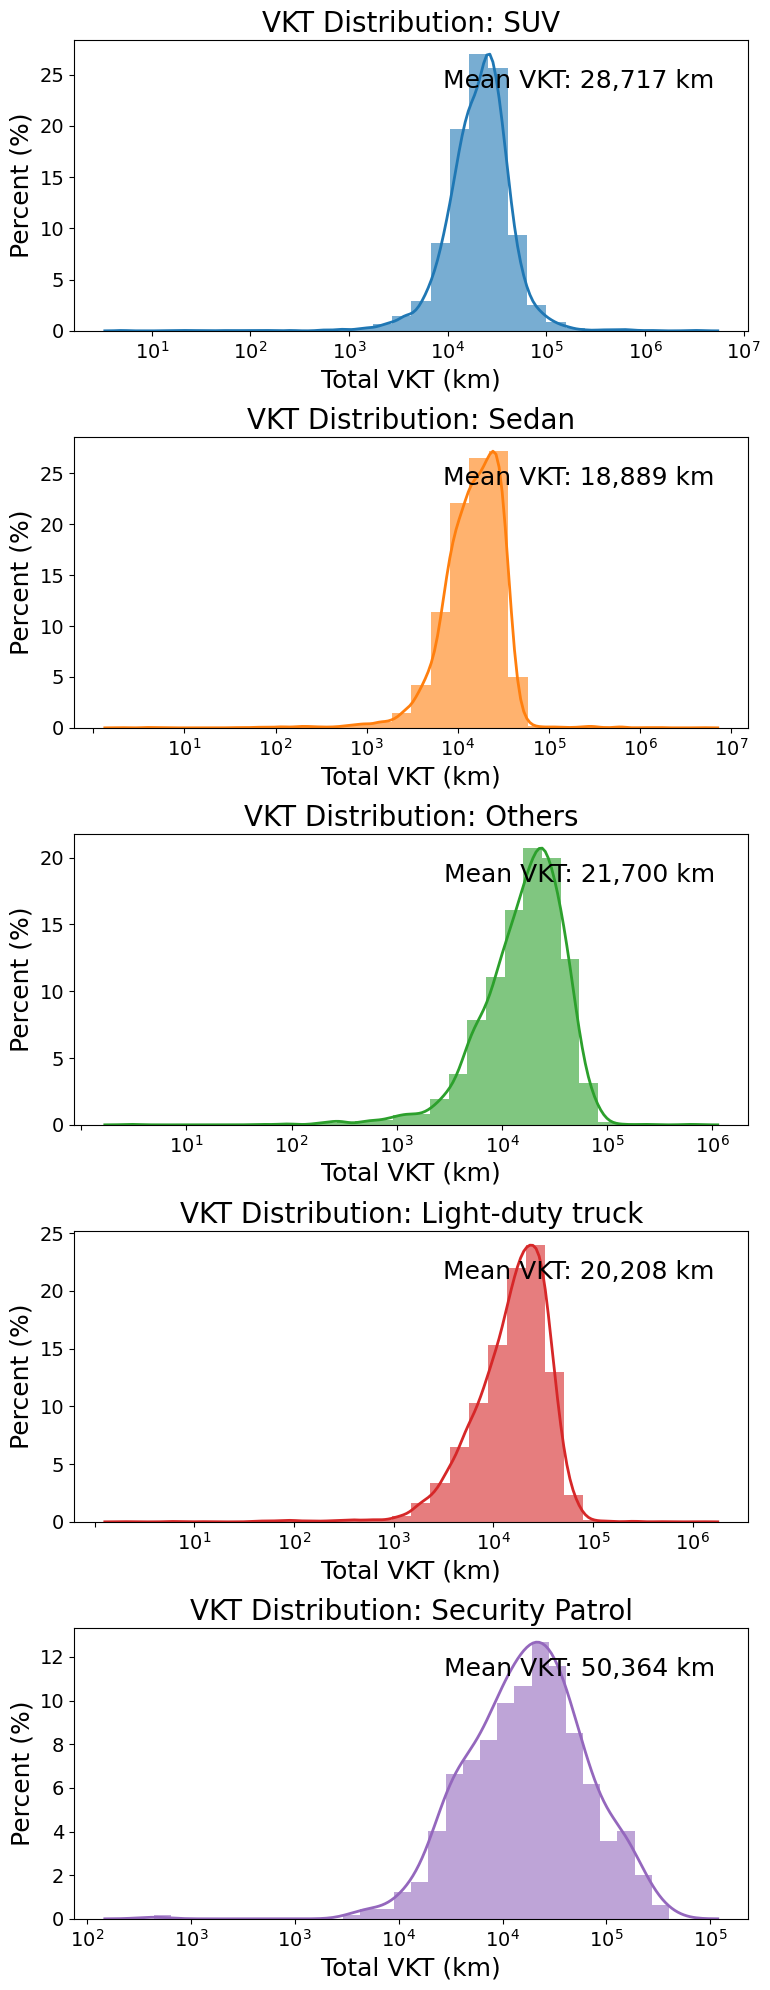

In [328]:
vkt_dist_visualization_subplots(df_new)
# vkt_distribution.to_csv(f'../../results/vkt_distribution_{year}.csv', index=False)
# Still need to convert the actual recorded vkt of each vehicle (for those cut in or step out during the year) to annual equaivalent vkt

In [294]:
df_new['Total VKT'] = df_new['Total VKT'].replace([np.inf, -np.inf], np.nan).dropna()
print(df_new[df_new['Vehicle Type'] == 'Others']['Total VKT'].mean(),
      df_new[df_new['Vehicle Type'] == 'Light-duty truck']['Total VKT'].mean(), 
      df_new[df_new['Vehicle Type'] == 'Security Patrol']['Total VKT'].mean(),
      df_new[df_new['Vehicle Type'] == 'Sedan']['Total VKT'].mean(),
      df_new[df_new['Vehicle Type'] == 'SUV']['Total VKT'].mean())


21699.50820985182 20207.75263807044 50363.59350850077 18888.783998972645 28716.557111913356
